In [1]:
import json
import pandas as pd,numpy as np,os
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from pathlib import Path
pio.templates.default = "simple_white"
print("importing..")
def preprocess_frames(df):

    check_na = pd.DataFrame(df.isna().sum(axis=1))
    check_na[1] = check_na[0].shift(1)
    check_na['remove'] = (check_na[0] == check_na[1]) & (check_na[0] != 0)
    final_df = df.drop(check_na[check_na['remove']].index, axis=0).fillna(0)
    return final_df


with open ("./data/character_to_prediction_index.json", 'r') as f:
    char_to_num = json.load(f)

len(char_to_num)

# Load the supplemental_metadata.csv file into memory
supplemental_df = pd.read_csv("./data/supplemental_metadata.csv")
train_df = pd.read_csv("./data/train.csv")
pd.set_option('display.max_columns', None)

train_df['y_len'] = train_df['phrase'].apply(len)
supplemental_df['y_len'] = supplemental_df['phrase'].apply(len)

supplemental_df.head(3)

importing..


,path,file_id,sequence_id,participant_id,phrase,y_len
0,supplemental_landmarks/33432165.parquet,33432165,1535467051,251,coming up with killer sound bites,33
1,supplemental_landmarks/33432165.parquet,33432165,1535499058,239,we better investigate this,26
2,supplemental_landmarks/33432165.parquet,33432165,1535530550,245,interesting observation was made,32


In [3]:
len(char_to_num)
char_to_num

{' ': 0,
 '!': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '*': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 ':': 25,
 ';': 26,
 '=': 27,
 '?': 28,
 '@': 29,
 '[': 30,
 '_': 31,
 'a': 32,
 'b': 33,
 'c': 34,
 'd': 35,
 'e': 36,
 'f': 37,
 'g': 38,
 'h': 39,
 'i': 40,
 'j': 41,
 'k': 42,
 'l': 43,
 'm': 44,
 'n': 45,
 'o': 46,
 'p': 47,
 'q': 48,
 'r': 49,
 's': 50,
 't': 51,
 'u': 52,
 'v': 53,
 'w': 54,
 'x': 55,
 'y': 56,
 'z': 57,
 '~': 58}

In [7]:
len(supplemental_df), len(train_df)

(52958, 67208)

In [9]:
supplemental_df.phrase.value_counts()

phrase
why do you ask silly questions            117
find a nearby parking spot                117
apartments are too expensive              116
what to do when the oil runs dry          115
that agreement is rife with problems      115
                                         ... 
saving that child was an heroic effort     17
you will loose your voice                  16
everybody looses in custody battles        15
if at first you do not succees              1
my favorite place is to visit               1
Name: count, Length: 508, dtype: int64

In [8]:
train_df.phrase.value_counts()

phrase
surprise az               17
fort worth tx             16
yonkers new york          16
raleigh north carolina    15
buffalo ny                14
                          ..
935-833-3505               1
kristyn barrera            1
henry fletcher             1
donte best                 1
994-392-3850               1
Name: count, Length: 46478, dtype: int64

# 1. On train_data : Pre-process

In [2]:
import os

ls = []

for i in os.listdir('./data/train_landmarks/'):
    tmp_df = pd.read_parquet(f"./data/train_landmarks/{i}").reset_index()

    x_right_hand = [f'x_right_hand_{i}' for i in range(21)]
    y_right_hand = [f'y_right_hand_{i}' for i in range(21)]
    z_right_hand = [f'z_right_hand_{i}' for i in range(21)]

    x_left_hand = [f'x_left_hand_{i}' for i in range(21)]
    y_left_hand = [f'y_left_hand_{i}' for i in range(21)]
    z_left_hand = [f'z_left_hand_{i}' for i in range(21)]

    ls += [tmp_df[['sequence_id','frame']+x_right_hand + y_right_hand + z_right_hand + x_left_hand + y_left_hand + z_left_hand]]

partial_train_landmark_df = pd.concat(ls)

In [3]:
# partial_train_landmark_df.to_parquet("./data/partial_train_landmark.parquet")
partial_train_landmark_df = pd.read_parquet("./data/partial_train_landmark.parquet")

In [6]:
def preprocess_frames(df):

    check_na = pd.DataFrame(df.isna().sum(axis=1))
    check_na[1] = check_na[0].shift(1)
    check_na['remove'] = (check_na[0] == check_na[1]) & (check_na[0] != 0)
    final_df = df.drop(check_na[check_na['remove']].index, axis=0).fillna(0)
    return final_df

In [7]:


sequence_df = partial_train_landmark_df.set_index("sequence_id")

result = []

for idx, row in train_df.iterrows():
    tmp_sequence_df = sequence_df.loc[row['sequence_id']]

    x_right_hand = [f'x_right_hand_{i}' for i in range(21)]
    y_right_hand = [f'y_right_hand_{i}' for i in range(21)]
    z_right_hand = [f'z_right_hand_{i}' for i in range(21)]

    x_left_hand = [f'x_left_hand_{i}' for i in range(21)]
    y_left_hand = [f'y_left_hand_{i}' for i in range(21)]
    z_left_hand = [f'z_left_hand_{i}' for i in range(21)]

    right_df = tmp_sequence_df[x_right_hand + y_right_hand + z_right_hand]
    right_df = right_df.reset_index()
    right_final_df = preprocess_frames(right_df)

    left_df = tmp_sequence_df[x_left_hand + y_left_hand + z_left_hand]
    left_df = left_df.reset_index()
    left_final_df = preprocess_frames(left_df)

    result += [{'idx':idx, 'right_len':len(right_final_df), 'left_len':len(left_final_df)}]

    break

In [8]:
left_final_df

,sequence_id,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,x_left_hand_10,x_left_hand_11,x_left_hand_12,x_left_hand_13,x_left_hand_14,x_left_hand_15,x_left_hand_16,x_left_hand_17,x_left_hand_18,x_left_hand_19,x_left_hand_20,y_left_hand_0,y_left_hand_1,y_left_hand_2,y_left_hand_3,y_left_hand_4,y_left_hand_5,y_left_hand_6,y_left_hand_7,y_left_hand_8,y_left_hand_9,y_left_hand_10,y_left_hand_11,y_left_hand_12,y_left_hand_13,y_left_hand_14,y_left_hand_15,y_left_hand_16,y_left_hand_17,y_left_hand_18,y_left_hand_19,y_left_hand_20,z_left_hand_0,z_left_hand_1,z_left_hand_2,z_left_hand_3,z_left_hand_4,z_left_hand_5,z_left_hand_6,z_left_hand_7,z_left_hand_8,z_left_hand_9,z_left_hand_10,z_left_hand_11,z_left_hand_12,z_left_hand_13,z_left_hand_14,z_left_hand_15,z_left_hand_16,z_left_hand_17,z_left_hand_18,z_left_hand_19,z_left_hand_20
0,1816796431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
right_final_df

,sequence_id,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,x_right_hand_16,x_right_hand_17,x_right_hand_18,x_right_hand_19,x_right_hand_20,y_right_hand_0,y_right_hand_1,y_right_hand_2,y_right_hand_3,y_right_hand_4,y_right_hand_5,y_right_hand_6,y_right_hand_7,y_right_hand_8,y_right_hand_9,y_right_hand_10,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,z_right_hand_0,z_right_hand_1,z_right_hand_2,z_right_hand_3,z_right_hand_4,z_right_hand_5,z_right_hand_6,z_right_hand_7,z_right_hand_8,z_right_hand_9,z_right_hand_10,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
0,1816796431,0.408832,0.519912,0.612159,0.707576,0.797313,0.494709,0.532817,0.553556,0.566219,0.391196,0.346564,0.329398,0.310256,0.303476,0.332645,0.407769,0.452754,0.241267,0.302987,0.372977,0.413130,0.828362,0.797813,0.729445,0.693900,0.677417,0.642394,0.556336,0.501643,0.452985,0.648080,0.552678,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1.438251e-06,-0.065295,-0.099489,-0.134330,-0.169376,-0.093553,-0.157288,-0.193133,-0.217873,-0.109475,-0.196916,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1,1816796431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1816796431,0.398663,0.523662,0.638807,0.744236,0.832567,0.538486,0.564302,0.581011,0.597674,0.441541,0.429515,0.441297,0.453220,0.355269,0.407275,0.455842,0.488949,0.292710,0.351343,0.406092,0.442418,0.805901,0.796239,0.744409,0.715357,0.681418,0.652149,0.591903,0.539250,0.494978,0.645438,0.578784,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1.699293e-06,-0.082688,-0.143600,-0.197512,-0.251108,-0.158306,-0.246869,-0.299608,-0.336924,-0.171088,-0.301972,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
4,1816796431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,1816796431,0.419290,0.509726,0.593165,0.685492,0.777913,0.483669,0.510993,0.536410,0.564583,0.393016,0.382989,0.413281,0.449161,0.318446,0.378528,0.484440,0.568851,0.265254,0.345995,0.435894,0.506857,0.815355,0.797622,0.742897,0.711665,0.693214,0.650615,0.575589,0.528461,0.487134,0.656149,0.574237,0.523051,0.477154,0.684504,0.644122,0.671142,0.694155,0.728935,0.714686,0.734443,0.748464,1.633807e-06,-0.070057,-0.119156,-0.165951,-0.213557,-0.115064,-0.191421,-0.239379,-0.273761,-0.132532,-0.229315,-0.285770,-0.318548,-0.155317,-0.274822,-0.312119,-0.316411,-0.181363,-0.286298,-0.316182,-0.322671
...,...,...,...,...,...,...,

# 2. Supplement dataset : preprocess

In [6]:
import os

ls = []
supplemental_df
for i in os.listdir('./data/supplemental_landmarks/'):
    tmp_df = pd.read_parquet(f"./data/supplemental_landmarks/{i}").reset_index()

    x_right_hand = [f'x_right_hand_{i}' for i in range(21)]
    y_right_hand = [f'y_right_hand_{i}' for i in range(21)]
    z_right_hand = [f'z_right_hand_{i}' for i in range(21)]

    x_left_hand = [f'x_left_hand_{i}' for i in range(21)]
    y_left_hand = [f'y_left_hand_{i}' for i in range(21)]
    z_left_hand = [f'z_left_hand_{i}' for i in range(21)]

    ls += [tmp_df[['sequence_id','frame']+x_right_hand + y_right_hand + z_right_hand + x_left_hand + y_left_hand + z_left_hand]]
    break
partial_supplemental_df = pd.concat(ls)



In [5]:
# partial_supplemental_df.to_parquet("./data/partial_supplemental_df.parquet")
partial_supplemental_df = pd.read_parquet("./data/partial_supplemental_df.parquet")


In [4]:

sequence_df = partial_supplemental_df.set_index("sequence_id")

result = []
except_ls = []
for idx, row in supplemental_df.iterrows():
    try:
        tmp_sequence_df = sequence_df.loc[row['sequence_id']]
    except:
        except_ls += [row['sequence_id']]
        continue
    x_right_hand = [f'x_right_hand_{i}' for i in range(21)]
    y_right_hand = [f'y_right_hand_{i}' for i in range(21)]
    z_right_hand = [f'z_right_hand_{i}' for i in range(21)]

    x_left_hand = [f'x_left_hand_{i}' for i in range(21)]
    y_left_hand = [f'y_left_hand_{i}' for i in range(21)]
    z_left_hand = [f'z_left_hand_{i}' for i in range(21)]

    right_df = tmp_sequence_df[x_right_hand + y_right_hand + z_right_hand]
    right_df = right_df.reset_index()
    right_final_df = preprocess_frames(right_df)

    left_df = tmp_sequence_df[x_left_hand + y_left_hand + z_left_hand]
    left_df = left_df.reset_index()
    left_final_df = preprocess_frames(left_df)

    result += [{'idx':idx, 'right_len':len(right_final_df), 'left_len':len(left_final_df)}]


In [6]:
# pd.DataFrame(result).to_parquet("./data/partial_supplemental_landmark01.parquet")
result = pd.read_parquet("./data/partial_supplemental_landmark01.parquet")


sequence_df1 = pd.concat([partial_supplemental_df, result])
supplemental_df1 = supplemental_df.reset_index().rename(columns = {'index':"idx"}).merge(result, on='idx', how='left')
supplemental_df1['frame_len'] = supplemental_df1[['right_len','left_len']].max(axis=1)
len(supplemental_df1[supplemental_df1['y_len'] >= supplemental_df1['frame_len']])/len(supplemental_df1)


0.13452169643868725

In [7]:
supplemental_df1[supplemental_df1['y_len'] <= supplemental_df1['frame_len']].to_parquet("./data/supplemental_possible.csv")

# Load saved dataset(preprocessed)

In [6]:
supplemental_df1 = pd.read_parquet("./data/supplemental_possible.csv")
train_df1 = pd.read_parquet("./data/train_possible.csv")

len(supplemental_df1), len(train_df1)

(46014, 60269)

In [ ]:
# pd.DataFrame(result).to_parquet("./data/partial_train_landmark01.parquet")
result = pd.read_parquet("./data/partial_train_landmark01.parquet")


sequence_df1 = pd.concat([partial_train_landmark_df, result])
train_df1 = train_df.reset_index().rename(columns = {'index':"idx"}).merge(result, on='idx', how='left')
train_df1['frame_len'] = train_df1[['right_len','left_len']].max(axis=1)
len(train_df1[train_df1['y_len'] >= train_df1['frame_len']])/len(train_df1)

train_df1[train_df1['y_len'] <= train_df1['frame_len']].to_parquet("./data/train_possible.csv")


,idx,right_len,left_len
0,0,53,1
1,1,60,1
2,2,141,1
3,3,237,1
4,4,245,1
...,...,...,...
52952,52953,107,1
52953,52954,203,1
52954,52955,58,1
52955,52956,177,1


In [6]:
train_df = pd.read_parquet("./data/train_possible.csv")
supple_df = pd.read_parquet("./data/supplemental_possible.csv")

In [10]:
test = pd.read_parquet(
    './data/partial_train_landmark.parquet'
)

In [11]:
test

,sequence_id,frame,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,x_right_hand_16,x_right_hand_17,x_right_hand_18,x_right_hand_19,x_right_hand_20,y_right_hand_0,y_right_hand_1,y_right_hand_2,y_right_hand_3,y_right_hand_4,y_right_hand_5,y_right_hand_6,y_right_hand_7,y_right_hand_8,y_right_hand_9,y_right_hand_10,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,z_right_hand_0,z_right_hand_1,z_right_hand_2,z_right_hand_3,z_right_hand_4,z_right_hand_5,z_right_hand_6,z_right_hand_7,z_right_hand_8,z_right_hand_9,z_right_hand_10,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,x_left_hand_10,x_left_hand_11,x_left_hand_12,x_left_hand_13,x_left_hand_14,x_left_hand_15,x_left_hand_16,x_left_hand_17,x_left_hand_18,x_left_hand_19,x_left_hand_20,y_left_hand_0,y_left_hand_1,y_left_hand_2,y_left_hand_3,y_left_hand_4,y_left_hand_5,y_left_hand_6,y_left_hand_7,y_left_hand_8,y_left_hand_9,y_left_hand_10,y_left_hand_11,y_left_hand_12,y_left_hand_13,y_left_hand_14,y_left_hand_15,y_left_hand_16,y_left_hand_17,y_left_hand_18,y_left_hand_19,y_left_hand_20,z_left_hand_0,z_left_hand_1,z_left_hand_2,z_left_hand_3,z_left_hand_4,z_left_hand_5,z_left_hand_6,z_left_hand_7,z_left_hand_8,z_left_hand_9,z_left_hand_10,z_left_hand_11,z_left_hand_12,z_left_hand_13,z_left_hand_14,z_left_hand_15,z_left_hand_16,z_left_hand_17,z_left_hand_18,z_left_hand_19,z_left_hand_20
0,450271163,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850211,0.779973,0.694400,0.658276,0.662199,0.612370,0.523930,0.466321,0.416245,0.676285,0.608345,0.563812,0.526677,0.751357,0.707486,0.663218,0.628045,0.832612,0.790072,0.764066,0.745585,0.795975,0.818180,0.820121,0.812789,0.797079,0.699216,0.653719,0.626585,0.603193,0.674222,0.610875,0.569227,0.532877,0.675586,0.624392,0.595527,0.567829,0.693166,0.703846,0.736529,0.763437,7.289119e-07,-0.055355,-0.090029,-0.118921,-0.149836,-0.067703,-0.101134,-0.124494,-0.145495,-0.077468,-0.103393,-0.131148,-0.153634,-0.093264,-0.145342,-0.195751,-0.230883,-0.110699,-0.176297,-0.208744,-0.228749
1,450271163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.799217,0.729479,0.647214,0.620249,0.650265,0.580478,0.501345,0.451209,0.408537,0.641138,0.580924,0.545980,0.516706,0.715691,0.678470,0.638927,0.606417,0.792166,0.745605,0.716330,0.696276,0.783988,0.798159,0.793549,0.783165,0.767457,0.678573,0.629456,0.603055,0.578194,0.658790,0.590346,0.550732,0.514471,0.662605,0.607485,0.570765,0.533674,0.682096,0.684912,0.718438,0.743581,6.007586e-07,-0.054402,-0.087671,-0.115183,-0.144999,-0.059262,-0.090465,-0.111289,-0.130837,-0.067697,-0.088252,-0.108135,-0.126339,-0.084145,-0.131306,-0.178627,-0.213141,-0.102693,-0.163479,-0.193422,-0.213809
2,450271163,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.746934,0.678349,0.607909,0.602171,0.635657,0.554719,0.477029,0.427827,0.384399,0.613954,0.557954,0.524014,

In [12]:
test1 = pd.read_parquet(
    './data/partial_train_landmark01.parquet'
)

# check frame len

In [2]:
result = pd.read_parquet("./data/partial_train_landmark01.parquet")
result1 = pd.read_parquet("./data/partial_supplemental_landmark01.parquet")
aa = result[['right_len','left_len']].max(axis=1).sort_values().values.tolist() + result1[['right_len','left_len']].max(axis=1).sort_values().values.tolist()
aa = np.array(aa)
prob = []

for i in range(600):
    prob += [sum(aa >= i)/len(aa)]

<Axes: >

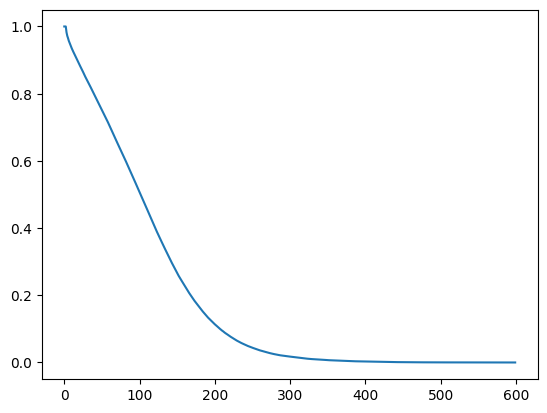

In [ ]:
pd.DataFrame(prob)[0].plot()

In [35]:
kk = pd.DataFrame(prob)
kk[kk[0] < 0.10]

,0
207,0.099771
208,0.097857
209,0.096085
210,0.094254
211,0.092772
...,...
595,0.000000
596,0.000000
597,0.000000
598,0.000000


<Axes: >

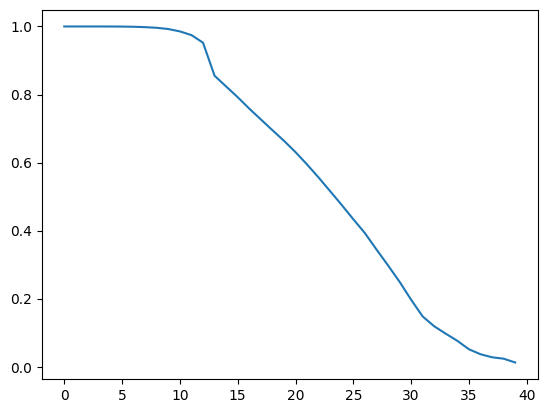

In [8]:
train_df = pd.read_parquet("./data/train_possible.csv")
supple_df = pd.read_parquet("./data/supplemental_possible.csv")
ll = pd.DataFrame(train_df['y_len'].values.tolist() + supple_df['y_len'].values.tolist())
ll[0].sort_values()

prob = []
for i in range(40):
    prob += [sum(ll.values >= i)/len(ll)]

pd.DataFrame(prob)[0].plot()

---

In [15]:
semi_preprocess_df = pd.read_parquet("./data/partial_train_landmark.parquet")
frame_df = semi_preprocess_df.set_index("sequence_id").loc[450271163].set_index("frame")

In [16]:
def preprocess_frames(df):
    '''
        df : partial (train_landmarks or supplemental_landmarks) which contains 
                frames, face, hand, pose data

                compress sequential na sets
                and replace na with zero

    '''
    
    check_na = pd.DataFrame(df.isna().sum(axis=1))
    check_na[1] = check_na[0].shift(1)
    check_na['remove'] = (check_na[0] == check_na[1]) & (check_na[0] != 0)
    final_df = df.drop(check_na[check_na['remove']].index, axis=0).fillna(0)
    return final_df

frame_df1 = preprocess_frames(frame_df)


right_hand = []
left_hand = []
for i in range(21):
    right_hand += [f'x_right_hand_{i}', f'y_right_hand_{i}', f'z_right_hand_{i}']
    left_hand += [f'x_left_hand_{i}', f'y_left_hand_{i}', f'z_left_hand_{i}']



right_df = frame_df[right_hand]
left_df = frame_df[left_hand]

right_df1 = preprocess_frames(right_df)
left_df1 = preprocess_frames(left_df)

In [37]:
max_len = 20

len(left_df1)
na_idx = left_df1[left_df1.sum(axis=1) == 0].index.tolist()
notna_idx = left_df1[left_df1.sum(axis=1) != 0].index.tolist()

rest_len = max_len - len(na_idx)
np.random.seed(42)
picked_notna_idx = np.random.choice(notna_idx, rest_len)

final_idx = na_idx + picked_notna_idx.tolist()



In [57]:

max_len = 40
number_of_pad_required = max_len - len(left_df1)
shape_in_row = left_df1.shape[-1]

In [56]:
left_df.shape[-1]

63

In [60]:
zero_df = pd.DataFrame(np.zeros([number_of_pad_required, shape_in_row]))
zero_df.columns = left_df.columns

In [67]:
left_df1.reset_index(drop=True).append(zero_df)

AttributeError: 'DataFrame' object has no attribute 'append'

In [70]:
pd.concat([left_df1, zero_df], ignore_index=True)

,x_left_hand_0,y_left_hand_0,z_left_hand_0,x_left_hand_1,y_left_hand_1,z_left_hand_1,x_left_hand_2,y_left_hand_2,z_left_hand_2,x_left_hand_3,y_left_hand_3,z_left_hand_3,x_left_hand_4,y_left_hand_4,z_left_hand_4,x_left_hand_5,y_left_hand_5,z_left_hand_5,x_left_hand_6,y_left_hand_6,z_left_hand_6,x_left_hand_7,y_left_hand_7,z_left_hand_7,x_left_hand_8,y_left_hand_8,z_left_hand_8,x_left_hand_9,y_left_hand_9,z_left_hand_9,x_left_hand_10,y_left_hand_10,z_left_hand_10,x_left_hand_11,y_left_hand_11,z_left_hand_11,x_left_hand_12,y_left_hand_12,z_left_hand_12,x_left_hand_13,y_left_hand_13,z_left_hand_13,x_left_hand_14,y_left_hand_14,z_left_hand_14,x_left_hand_15,y_left_hand_15,z_left_hand_15,x_left_hand_16,y_left_hand_16,z_left_hand_16,x_left_hand_17,y_left_hand_17,z_left_hand_17,x_left_hand_18,y_left_hand_18,z_left_hand_18,x_left_hand_19,y_left_hand_19,z_left_hand_19,x_left_hand_20,y_left_hand_20,z_left_hand_20
0,0.850211,0.795975,7.289119e-07,0.779973,0.818180,-0.055355,0.694400,0.820121,-0.090029,0.658276,0.812789,-0.118921,0.662199,0.797079,-0.149836,0.612370,0.699216,-0.067703,0.523930,0.653719,-0.101134,0.466321,0.626585,-0.124494,0.416245,0.603193,-0.145495,0.676285,0.674222,-0.077468,0.608345,0.610875,-0.103393,0.563812,0.569227,-0.131148,0.526677,0.532877,-0.153634,0.751357,0.675586,-0.093264,0.707486,0.624392,-0.145342,0.663218,0.595527,-0.195751,0.628045,0.567829,-0.230883,0.832612,0.693166,-0.110699,0.790072,0.703846,-0.176297,0.764066,0.736529,-0.208744,0.745585,0.763437,-0.228749
1,0.799217,0.783988,6.007586e-07,0.729479,0.798159,-0.054402,0.647214,0.793549,-0.087671,0.620249,0.783165,-0.115183,0.650265,0.767457,-0.144999,0.580478,0.678573,-0.059262,0.501345,0.629456,-0.090465,0.451209,0.603055,-0.111289,0.408537,0.578194,-0.130837,0.641138,0.658790,-0.067697,0.580924,0.590346,-0.088252,0.545980,0.550732,-0.108135,0.516706,0.514471,-0.126339,0.715691,0.662605,-0.084145,0.678470,0.607485,-0.131306,0.638927,0.570765,-0.178627,0.606417,0.533674,-0.213141,0.792166,0.682096,-0.102693,0.745605,0.684912,-0.163479,0.716330,0.718438,-0.193422,0.696276,0.743581,-0.213809
2,0.746934,0.774575,5.029622e-07,0.678349,0.778539,-0.035915,0.607909,0.768382,-0.064237,0.602171,0.768129,-0.090162,0.635657,0.763960,-0.121496,0.554719,0.668744,-0.061699,0.477029,0.616506,-0.093008,0.427827,0.593193,-0.112352,0.384399,0.571623,-0.130676,0.613954,0.652824,-0.079763,0.557954,0.580869,-0.106407,0.524014,0.540721,-0.131652,0.498247,0.503776,-0.153116,0.687573,0.656753,-0.102476,0.650771,0.600174,-0.154591,0.609794,0.561744,-0.205599,0.576316,0.521820,-0.242489,0.761928,0.676404,-0.124570,0.714291,0.684182,-0.184529,0.680970,0.716384,-0.212316,0.659042,0.739567,-0.231991
3,0.792749,0.816055,5.109025e-07,0.715998,0.823586,-0.041595,0.615457,0.807472,-0.064291,0.583914,0.782588,-0.083351,0.619326,0.756413,-0.104155,0.564589,0.690183,-0.035743,0.487853,0.641650,-0.062729,0.436848,0.609943,-0.085500,0.390543,0.583187,-0.107986,0.625546,0.670499,-0.052147,0.564648,0.606715,-0.075570,0.526803,0.563395,-0.102535,0.494095,0.525966,-0.124609,0.694536,0.673670,-0.075734,0.643784,0.616616,-0.123845,0.602937,0.575137,-0.169882,0.570878,0.533966,-0.203251,0.765936,0.693192,-0.100899,0.699752,0.685182,-0.163232,0.661952,0.712836,-0.191301,0.634987,0.736272,-0.209427
4,0.748483,0.799999,-1.235130e-07,0.661795,0.807300,-0.015703,0.578082,0.784967,-0.020643,0.552502,0.767276,-0.027221,0.577065,0.748039,-0.036796,0.521850,0.672700,0.007234,0.448362,0.624946,0.005545,0.414622,0.606269,0.001623,0.381391,0.583989,-0.008421,0.582414,0.653357,-0.011423,0.547876,0.583467,-0.011089,0.527910,0.552729,-0.021602,0.515144,0.521263,-0.034823,0.652822,0.660188,-0.036247,0.619466,0.616969,-0.069445,0.571991,0.581509,-0.115044,0.536515,0.544796,-0.150894,0.718673,0.682689,-0.059755,0.673176,0.699994,-0.102723,0.627214,0.732747,-0.125831,0.597174,0.757602,-0.144639
5,0.796546,0.848732,4.131125e-07,0.711599,0.852827,-0.036277,0.603154,0.834457,-0.056623,0.566013,0.806747,-0.074517,0.60

In [19]:

check_na = pd.DataFrame(left_df.isna().sum(axis=1))
check_na[1] = check_na[0].shift(1)
check_na['remove'] = (check_na[0] == check_na[1]) & (check_na[0] != 0)
final_df = left_df.drop(check_na[check_na['remove']].index, axis=0).fillna(0)


In [44]:
left_df.iloc[0]

x_left_hand_0     8.502105e-01
y_left_hand_0     7.959749e-01
z_left_hand_0     7.289119e-07
x_left_hand_1     7.799730e-01
y_left_hand_1     8.181800e-01
                      ...     
y_left_hand_19    7.365290e-01
z_left_hand_19   -2.087436e-01
x_left_hand_20    7.455853e-01
y_left_hand_20    7.634374e-01
z_left_hand_20   -2.287490e-01
Name: 0, Length: 63, dtype: float32

In [15]:
frame_df.columns.tolist()

['x_right_hand_0',
 'x_right_hand_1',
 'x_right_hand_2',
 'x_right_hand_3',
 'x_right_hand_4',
 'x_right_hand_5',
 'x_right_hand_6',
 'x_right_hand_7',
 'x_right_hand_8',
 'x_right_hand_9',
 'x_right_hand_10',
 'x_right_hand_11',
 'x_right_hand_12',
 'x_right_hand_13',
 'x_right_hand_14',
 'x_right_hand_15',
 'x_right_hand_16',
 'x_right_hand_17',
 'x_right_hand_18',
 'x_right_hand_19',
 'x_right_hand_20',
 'y_right_hand_0',
 'y_right_hand_1',
 'y_right_hand_2',
 'y_right_hand_3',
 'y_right_hand_4',
 'y_right_hand_5',
 'y_right_hand_6',
 'y_right_hand_7',
 'y_right_hand_8',
 'y_right_hand_9',
 'y_right_hand_10',
 'y_right_hand_11',
 'y_right_hand_12',
 'y_right_hand_13',
 'y_right_hand_14',
 'y_right_hand_15',
 'y_right_hand_16',
 'y_right_hand_17',
 'y_right_hand_18',
 'y_right_hand_19',
 'y_right_hand_20',
 'z_right_hand_0',
 'z_right_hand_1',
 'z_right_hand_2',
 'z_right_hand_3',
 'z_right_hand_4',
 'z_right_hand_5',
 'z_right_hand_6',
 'z_right_hand_7',
 'z_right_hand_8',
 'z_right

# Explore LandMark

In [ ]:
adj_matrix = [
    #0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],

]